In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy as sp

In [2]:
plt.rcParams['font.size'] = 18
plt.rcParams['font.family']='Times New Roman'

In [3]:
def survive_sp(abun,thres):
    N=0
    for i in abun:
        if i > thres:
            N += 1
    return N

def xdot1_mod (s_vec, t, M, NN, TN,C, pn, p, rm, K1, K2, Kt1, Kt2, S1, S2, A, a, F,f1,f2):
    X_vec = s_vec[:-(NN+TN)]
    N_vec = s_vec[M:M+NN]
    T_vec = s_vec[M+NN:]
    Gx = [X_vec[i]*rm/(1+1/((N_vec[0]/K1[i]))) for i in range(M)]
    
    N1dot = (A[0] - N_vec[0]) * F - sum([a*b for a, b in zip(S1,Gx)]) 
    N2dot = (A[1] - N_vec[1]) * F - sum([a*b for a, b in zip(S2,Gx)]) 
    T1dot = (a[0] - T_vec[0]) * F
    T2dot = (a[1] - T_vec[1]) * F 

    dydl = [a - b for a,b in zip(Gx,[F * i for i in X_vec])] + [N1dot , N2dot , T1dot , T2dot]
    return dydl



In [4]:
# parameters
## What do we need ? tradeoff between 

M = 2
NN = 2
TN = 2
C1 = [0.1,0.1]
C2 = [0.1,0.1]
C = [C1,C2]
pn = -0
p = 3
rm = 1.2
K1 = [1.35,1.7]
K2 = [0.00001,0.00001]
Kt1 = [2.2,4]
Kt2 = [10000000,10000000]
S1 = [1,1]
S2 = [1,1]
A = [1,10000000]
a = [2.2,0]
F = 0.2
f1 = [0.,0.]
f2 = [0.,0.]



#other parameters
#pn = -2 ; f=0.8 ; p=3, F = 0.2

In [5]:
# random sampling given constraint, defined by pc

end_time = 5000 #length of simulation (4)
time_points = end_time*10+1
t=np.linspace(0,end_time,time_points)

init_cond = [0.4,0.4,0,0,0.,0.]
x0 = init_cond


def SelectNutrient_toxinGrowth(p,Cst,Kt1):

    M = 2
    NN = 2
    TN = 2
    C1 = [0.1,0.1]
    C2 = [0.1,0.1]
    C = [C1,C2]
    pn = -0
    rm = 1.2


    S1 = [1,1]
    S2 = [1,1]
    A = [2,10000000]
    a = [2,0]
    F = 0.2
    f1 = [0.,0.]
    f2 = [0.,0.]

    # nutrient and toxin 2 are not growth limiting
    K2 = [0.00001,0.00001]
    Kt2 = [10000000,10000000]


#   Constraint
    Kunit = 1
#     Kt1 = np.random.rand(2)+1
    K1 = [(Cst - 1 / (i**p) )*Kunit for i in Kt1]




    solution=odeint(xdot1_mod, x0, t, args = (M, NN, TN,C, pn, p, rm, K1, K2, Kt1, Kt2, S1, S2, A, a, F, f1,f2))
    selection_curve= np.log(solution[:,0]/solution[:,1])

    return(np.mean(np.gradient(selection_curve)[5000:10000]))


In [6]:
sampling_size = 100
Kt1_all = np.array([[np.random.rand()*12+2,3] for i in range(sampling_size)])
p=[0.4,1,3]
p=[0.7]
p=[0.1]
p=[2]
p=[0.1,1,2]
Cst = [5,6,8]

select_coef = [[[] for i in range(len(p))] for j in range(len(Cst))]

for cst in range(len(Cst)):
    print(cst)
    for pp in range(len(p)):
        for re in range(sampling_size):
            select_coef[cst][pp].append(SelectNutrient_toxinGrowth(p[pp],Cst[cst],Kt1_all[re]))


0


/Users/samlui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/Users/samlui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


1
2


In [7]:
def fitness_diff(k1, kx):
    if k1 <= kx:
        Nstar = k1/(rm/F-1)
    else:
        Nstar = kx/(rm/F-1)
    return rm/(1+k1/Nstar)-rm/(1+kx/Nstar)
#     return Nstar

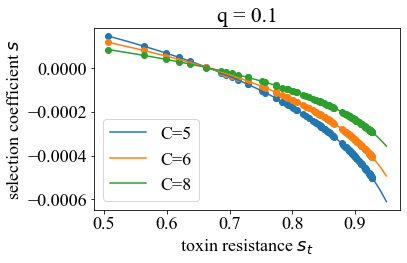

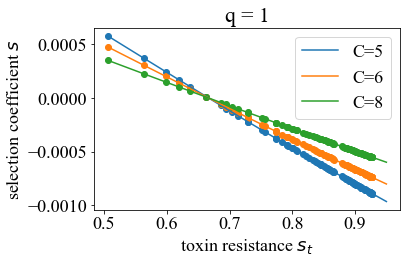

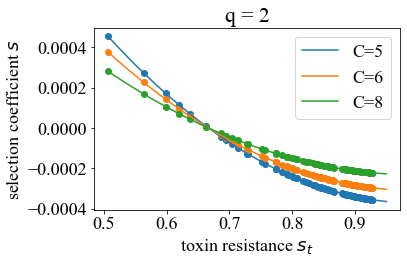

In [8]:
kt_an_inv = np.arange(0.05,0.5,0.01)
kt_an = np.array([1/i for i in kt_an_inv])

for pp in range(len(p)):
    for cst in range(len(Cst)):
        plt.figure(pp)
        plt.scatter(1-1/Kt1_all[:,0],select_coef[cst][pp])
        plt.ylabel(r'selection coefficient $s$')
        plt.xlabel(r'toxin resistance $s_t$')
        plt.title('q = '+str(p[pp]))
        kn_an = [Cst[cst] - 1/i**p[pp] for i in kt_an]
        ss = [fitness_diff(i,Cst[cst]-1/3**p[pp]) for i in kn_an]
        plt.plot(1-1/kt_an,np.array(ss)/10)
        plt.legend(['C=5','C=6','C=8'])

    plt.tight_layout()


In [9]:
def sigmoid(x,a,b,c,d):
    return d-a/(1 + np.exp(-c * (x - b)))

def linear(x,a,b):
    return a*x+b

def quadratic(x,a1,a2,b):
    return a1*x+a2*x**2+b

def fit_curve(f,x,y):
    popt,pcov = sp.optimize.curve_fit(f,x,y)
    print(pcov)
    return tuple(popt)

In [10]:
# from Ferenci et al (2017)
CM=np.genfromtxt('cm.csv', delimiter=',')[1:]
cmA1,cmA2,cmB=fit_curve(quadratic,CM[:,0],CM[:,1])


CF=np.genfromtxt('cf.csv', delimiter=',')[1:]
cfA,cfB=fit_curve(linear,CF[:,0],CF[:,1])

ST=np.genfromtxt('st.csv', delimiter=',')[1:]
stA,stB,stC,stD=fit_curve(sigmoid,ST[:,0],ST[:,1])


[[ 2.57320492e-04 -2.59157438e-05 -4.17212483e-04]
 [-2.59157438e-05  2.73983171e-06  3.71181773e-05]
 [-4.17212483e-04  3.71181773e-05  9.63147929e-04]]
[[ 0.00010264 -0.00033906]
 [-0.00033906  0.00144199]]
[[ 3.69053056e-02 -4.34295065e-03 -4.18497749e-01  2.86993527e-02]
 [-4.34295065e-03  2.95819640e-01 -3.90369728e-01 -1.80070751e-02]
 [-4.18497749e-01 -3.90369728e-01  6.11620845e+00 -3.24489523e-01]
 [ 2.86993527e-02 -1.80070751e-02 -3.24489523e-01  2.40857400e-02]]


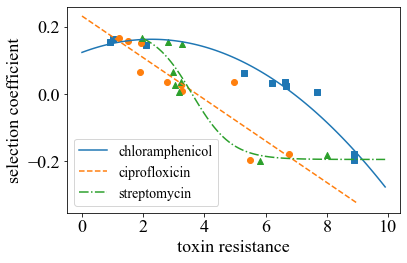

In [11]:
plt.plot(np.arange(0,10,0.1),[quadratic(i,cmA1,cmA2,cmB) for i in np.arange(0,10,0.1)])
plt.scatter(CM[:,0],CM[:,1],marker='s')

plt.plot(np.arange(10),[linear(i,cfA,cfB) for i in np.arange(10)],'--')
plt.scatter(CF[:,0],CF[:,1],marker='o')

plt.plot(np.arange(2,10,0.1),[sigmoid(i,stA,stB,stC,stD) for i in np.arange(2,10,0.1)],'-.')
plt.scatter(ST[:,0],ST[:,1],marker='^')

plt.legend(['chloramphenicol','ciprofloxicin','streptomycin'],loc=3, prop={'size': 14})


plt.ylabel('selection coefficient')
plt.xlabel('toxin resistance')
plt.gca().set_aspect('auto')
plt.tight_layout()
# plt.savefig('shape_of_tradeoff_toxindata.pdf')